In [1]:
!unzip /content/drive/MyDrive/data/CelebA/Img/img_align_celeba.zip -d celeba

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: celeba/img_align_celeba/197600.jpg  
 extracting: celeba/img_align_celeba/197601.jpg  
 extracting: celeba/img_align_celeba/197602.jpg  
 extracting: celeba/img_align_celeba/197603.jpg  
 extracting: celeba/img_align_celeba/197604.jpg  
 extracting: celeba/img_align_celeba/197605.jpg  
 extracting: celeba/img_align_celeba/197606.jpg  
 extracting: celeba/img_align_celeba/197607.jpg  
 extracting: celeba/img_align_celeba/197608.jpg  
 extracting: celeba/img_align_celeba/197609.jpg  
 extracting: celeba/img_align_celeba/197610.jpg  
 extracting: celeba/img_align_celeba/197611.jpg  
 extracting: celeba/img_align_celeba/197612.jpg  
 extracting: celeba/img_align_celeba/197613.jpg  
 extracting: celeba/img_align_celeba/197614.jpg  
 extracting: celeba/img_align_celeba/197615.jpg  
 extracting: celeba/img_align_celeba/197616.jpg  
 extracting: celeba/img_align_celeba/197617.jpg  
 extracting: celeba/img_align_celeba/197618.jpg  
 extracting: c

In [2]:
import glob
imgs = glob.glob('/content/celeba/img_align_celeba/*.jpg')
imgs[:10]

['/content/celeba/img_align_celeba/140646.jpg',
 '/content/celeba/img_align_celeba/124381.jpg',
 '/content/celeba/img_align_celeba/077580.jpg',
 '/content/celeba/img_align_celeba/158646.jpg',
 '/content/celeba/img_align_celeba/148810.jpg',
 '/content/celeba/img_align_celeba/000642.jpg',
 '/content/celeba/img_align_celeba/057003.jpg',
 '/content/celeba/img_align_celeba/059732.jpg',
 '/content/celeba/img_align_celeba/009832.jpg',
 '/content/celeba/img_align_celeba/042819.jpg']

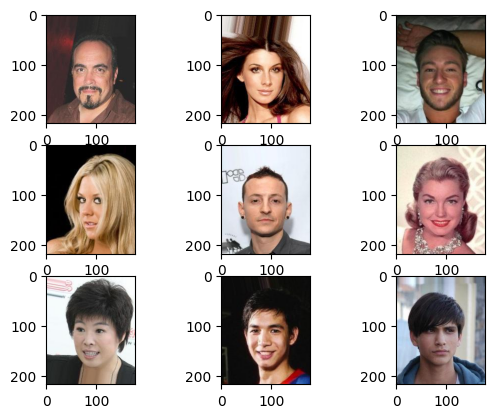

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
for i in range(9):
  plt.subplot(3,3,i+1)
  img = Image.open(imgs[i])
  plt.imshow(img)
plt.show()

In [4]:
# 학습용데이터셋
import torch
import torchvision.transforms as tf

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize((0.4,0.4,0.4),(0.2,0.2,0.2))
])


In [5]:
dataset = ImageFolder(
    root = '/content/celeba',
    transform = transforms
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)
a,b = next(iter(loader))
a.shape, b.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

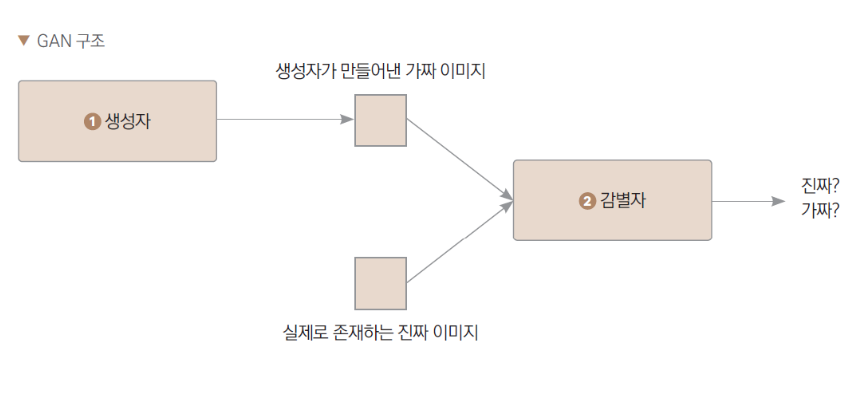

특징공간

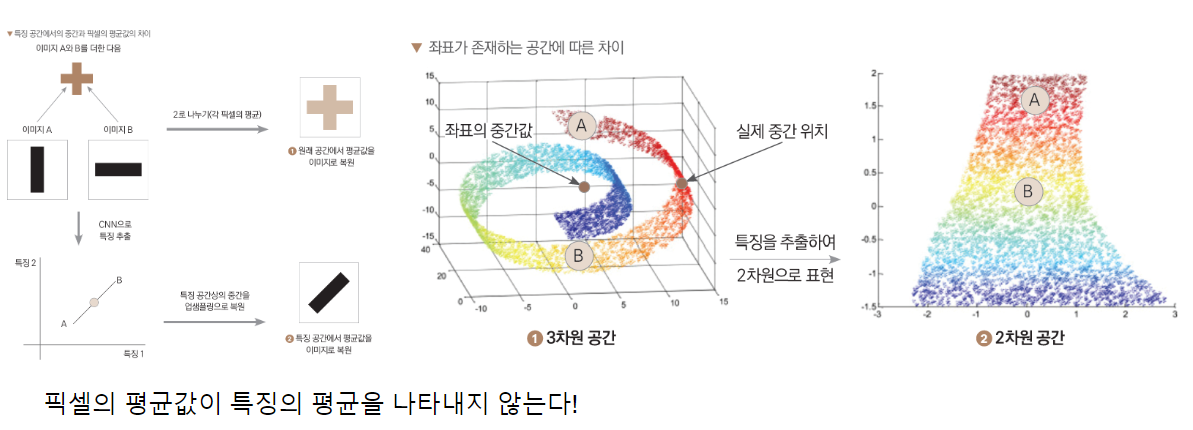

In [6]:
# 데이터는 100개를 사용
# 생성자
# [업셈플링->배치정규화->Relu 활성화 ] x 4
# 감별자

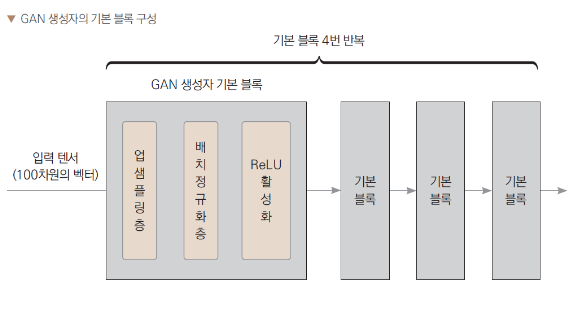

In [7]:
import torch.nn as nn
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    # 생성자를 구성하는 층 정의
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(100,512,kernel_size=4,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(512,256,kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256,128,kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128,64,kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64,3,kernel_size=4,stride=2, padding=1, bias=False),
        nn.Tanh()  # 원점에 대해서 대칭적인 함수이므로 어두운 색과 밝은색을 대칭적으로 학습
    )
  def forward(self, x):
    return self.gen(x)

감별자
  - 기존 CNN과 유사

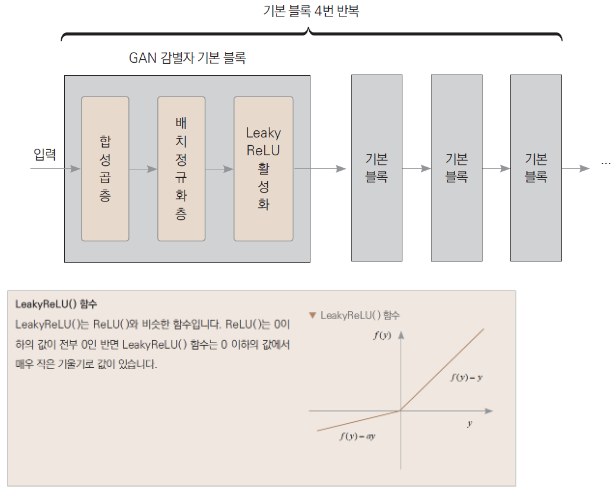

In [8]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    # 생성자를 구성하는 층 정의
    self.disc = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512,1,kernel_size=4),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.disc(x)

가중치 초기화

In [9]:
def weights_init(m):
  # 층의 종류 추출
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    # 합성곱 초기화
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm') != -1:
    # 배치정규화 층 초기화
    nn.init.normal_(m.weight.data,1.0, 0.02 )
    nn.init.constant_(m.bias.data, 0)   # 정규분포를 따르도록 가중치를 초기화

학습

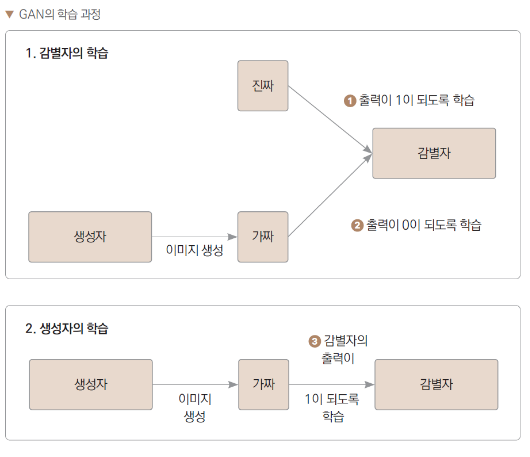

In [10]:
import tqdm
from torch.optim.adam import Adam

In [11]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
# 생성자 정의
G = Generator().to(device)
# 생성자 가중치 초기화
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
D.apply(weights_init)

G_optim = Adam(G.parameters(), lr = 1e-4, betas=(0.5,0.999))
D_optim = Adam(D.parameters(), lr = 1e-4, betas=(0.5,0.999))

In [ ]:

for epoch in range(10):
  iterator = tqdm.tqdm(enumerate(loader,0), total=len(loader))
  for i, data in iterator:
    D_optim.zero_grad()
    # 실제 이미지는 1, 생성된 이미지는 0으로 정답 생성
    label = torch.ones_like(  data[1], dtype=torch.float32 ).to(device)
    label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

    # 실제 이미지를 감별자에 입력
    real = D(data[0].to(device))

    # 실제 이미지에 대한 감별자의 오차 계산
    Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
    Dloss_real.backward()

    # 가짜 이미지를 생성
    noise = torch.randn(label.shape[0],100,1,1,device=device)
    fake = G(noise)

    # 가짜 이미지를 감별자에 입력
    output = D(fake.detach())

    # 가짜 이미지에 대한 감별자의 오차 계산
    Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
    Dloss_fake.backward()

    # 감별자의 전체 오차를 학습
    Dloss = Dloss_real + Dloss_fake
    D_optim.step()

    # 생성자의 학습
    G_optim.zero_grad()
    output = D(fake)
    Gloss = nn.BCELoss()(torch.squeeze(output), label)
    Gloss.backward()

    G_optim.step()

    iterator.set_description(f"epoch:{epoch} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

In [14]:
torch.save(G.state_dict(), '/content/drive/MyDrive/data/Generator.pth')
torch.save(D.state_dict(), '/content/drive/MyDrive/data/Discriminator.pth')

모델 성능 확인

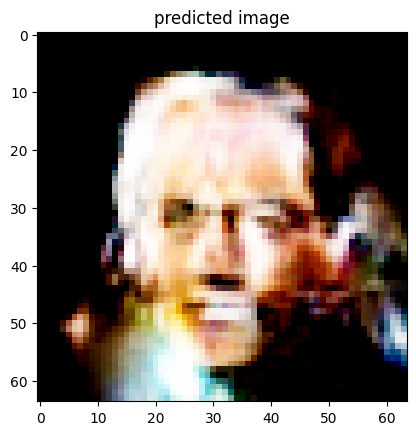

In [15]:
with torch.no_grad():
  G.load_state_dict(torch.load('/content/drive/MyDrive/data/Generator.pth',map_location=device))
  # 특징공간의 랜덤한 하나의 점 지정
  feature_vector = torch.randn(1,100,1,1).to(device)
  # 이미지 생성
  pred = G(feature_vector).squeeze()
  pred = pred.permute(1,2,0).cpu().numpy()

  plt.imshow(pred)
  plt.title("predicted image")
  plt.show()
